In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings("ignore")
import config

<IPython.core.display.Javascript object>

In [7]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from houseprices", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

* Investigate the data, and do any necessary data cleaning.
* Explore the data and find some variables that you think would be useful in predicting house prices.
* Build your initial model using these features and estimate the parameters using OLS.

In [8]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


<IPython.core.display.Javascript object>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

<IPython.core.display.Javascript object>

In [10]:
df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


<IPython.core.display.Javascript object>

In [18]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

<IPython.core.display.Javascript object>

In [20]:
df_num = df.select_dtypes(include=["float64", "int64"])
df_ob = df.select_dtypes(include=["O"])
num_cols = df_num.columns
ob_cols = df_ob.columns
print(num_cols)
print(ob_cols)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'he

<IPython.core.display.Javascript object>

In [13]:
df.isnull().sum().sort_values(ascending=False).head(20) / len(df)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
dtype: float64

<IPython.core.display.Javascript object>

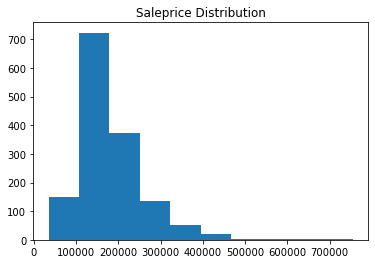

<IPython.core.display.Javascript object>

In [16]:
plt.hist(x=df.saleprice)
plt.title("Saleprice Distribution")
plt.show()

In [21]:
np.abs(df[num_cols].iloc[:, 1:].corr().loc[:, "saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

<IPython.core.display.Javascript object>

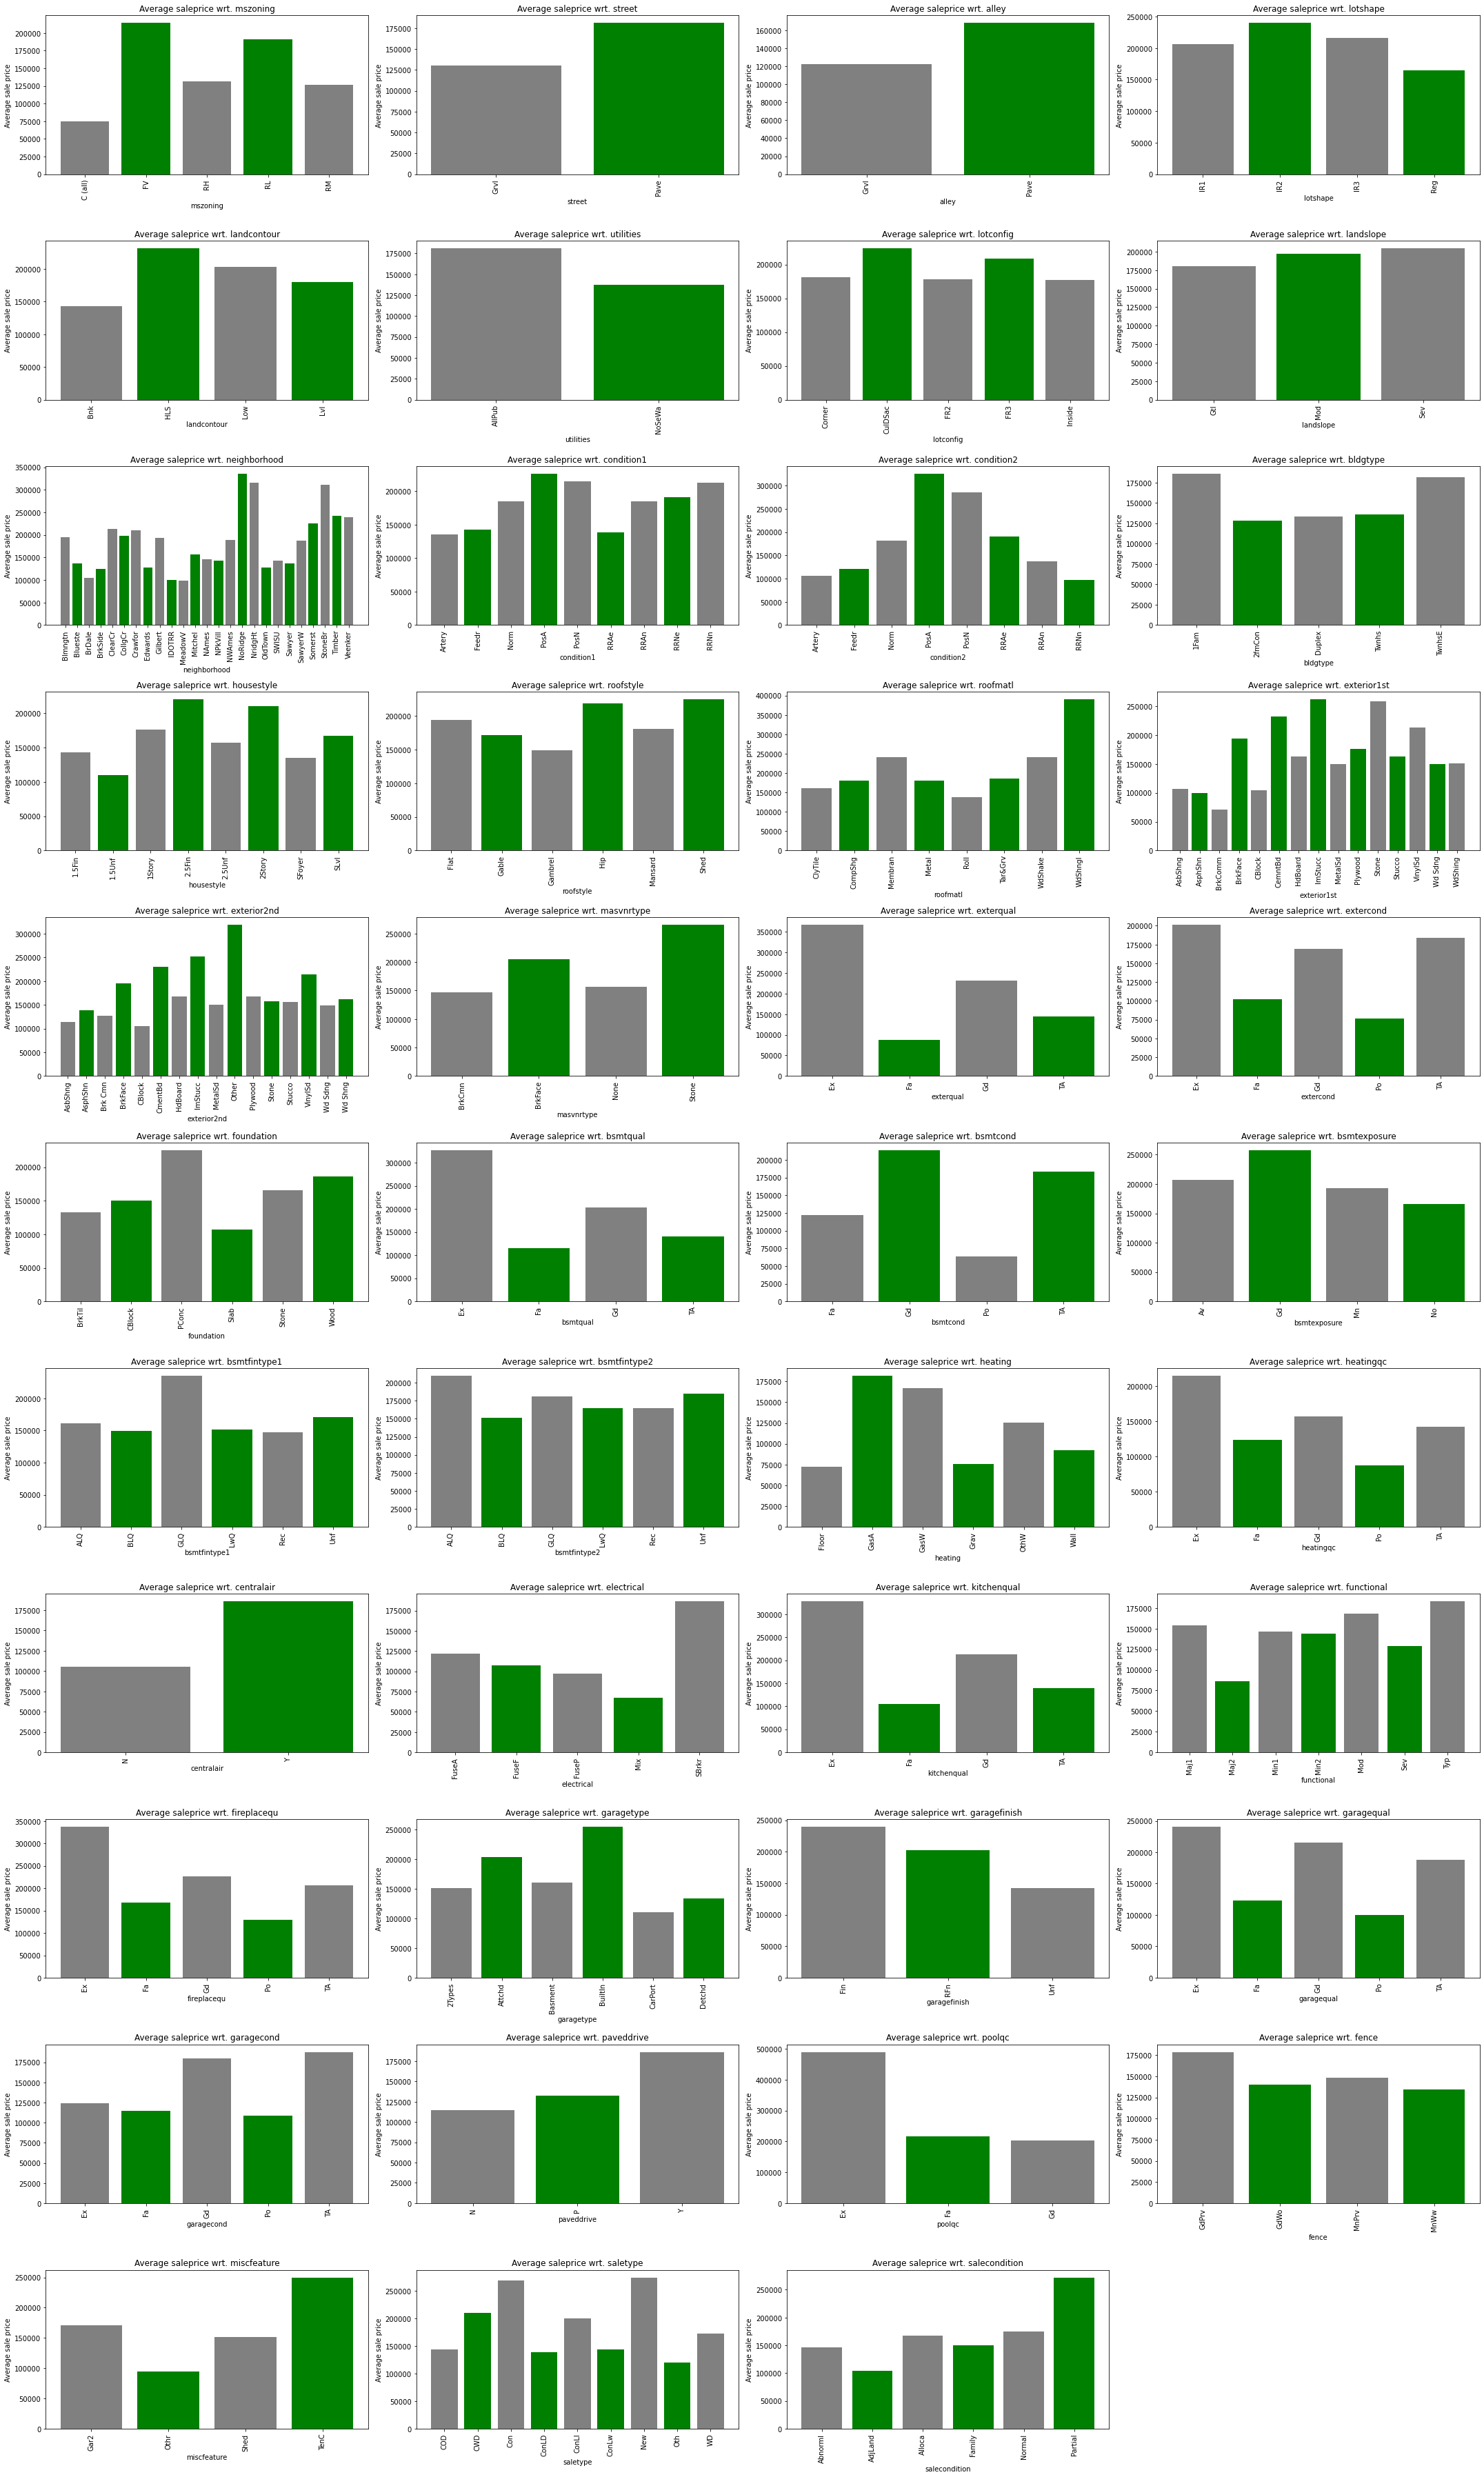

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(30, 50))

for index, column in enumerate(ob_cols):
    plt.subplot(11, 4, index + 1)
    plt.bar(
        df.groupby(column)["saleprice"].mean().index,
        df.groupby(column)["saleprice"].mean(),
        color=("grey", "green"),
    )
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

In [30]:
df = pd.concat(
    [df, pd.get_dummies(df.condition1, prefix="condition1", drop_first=True)], axis=1
)
df = pd.concat(
    [df, pd.get_dummies(df.condition2, prefix="condition2", drop_first=True)], axis=1
)
dummy_cols = list(
    pd.get_dummies(df.condition1, prefix="condition1", drop_first=True).columns
)
dummy_cols = dummy_cols + list(
    pd.get_dummies(df.condition2, prefix="condition2", drop_first=True).columns
)

<IPython.core.display.Javascript object>

In [27]:
df.condition2.isnull().sum()

0

<IPython.core.display.Javascript object>

In [31]:
X = df[
    ["overallqual", "grlivarea", "garagecars", "garagearea", "totalbsmtsf"] + dummy_cols
]
y = df.saleprice

<IPython.core.display.Javascript object>

In [34]:
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     243.5
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:17:40   Log-Likelihood:                -17465.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1439   BIC:                         3.508e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.093e+05   2.72e+04     -4.015      0.000   -1.63e+05   -5.59e+04
overallqual       2.293e+04   1075.527     21.322      0.000    2.08e+04     2.5e+04
grlivarea           48.2718      2.499     19.320      0.000      43.371      53.173
garagecars        1.239e+04   3006.773      4.120      0.000    6489.918    1.83e+04
garagearea          23.6586     10.385      2.278      0.023       3.288      44.029
totalbsmtsf         31.6301      2.881     10.980      0.000      25.979      37.281
condition1_Feedr  3547.5899   2397.440      1.480      0.139   -1155.261    8250.441
condition1_Feedr  3547.5899   2397.440      1.480      0.139   -1155.261    8250.441
condition1_Feedr  3547.5899   2397.440      1.480      0.139   -1155.261    8250.441
condition1_Norm   8392.6039   1947.877      4.309      0.000    4571.620    1.22e+04
condition1_Norm   8392.6039   1947.877      4.309      0.000    4571.620    1.22e+04
condition1_Norm   8392.6039   1947.877      4.309      0.000    4571.620    1.22e+04
condition1_PosA   6203.8315   4903.281      1.265      0.206   -3414.512    1.58e+04
condition1_PosA   6203.8315   4903.281      1.265      0.206   -3414.512    1.58e+04
condition1_PosA   6203.8315   4903.281      1.265      0.206   -3414.512    1.58e+04
condition1_PosN   6385.2397   3640.266      1.754      0.080    -755.557    1.35e+04
condition1_PosN   6385.2397   3640.266      1.754      0.080    -755.557    1.35e+04
condition1_PosN   6385.2397   3640.266      1.754      0.080    -755.557    1.35e+04
condition1_RRAe   1360.4238   4295.118      0.317      0.751   -7064.939    9785.786
condition1_RRAe   1360.4238   4295.118      0.317      0.751   -7064.939    9785.786
condition1_RRAe   1360.4238   4295.118      0.317      0.751   -7064.939    9785.786
condition1_RRAn   6791.2694   3268.693      2.078      0.038     379.355    1.32e+04
condition1_RRAn   6791.2694   3268.693      2.078      0.038     379.355    1.32e+04
condition1_RRAn   6791.2694   3268.693      2.078      0.038     379.355    1.32e+04
condition1_RRNe   4915.9965   9208.770      0.534      0.594   -1.31e+04     2.3e+04
condition1_RRNe   4915.9965   9208.770      0.534      0.594   -1.31e+04     2.3e+04
condition1_RRNe   4915.9965   9208.770      0.534      0.594   -1.31e+04     2.3e+04
condition1_RRNn   8315.1946   6133.890      1.356      0.175   -3717.129    2.03e+04
condition1_RRNn   8315.1946   6133.890      1.356      0.175   -3717.129    2.03e+04
condition1_RRNn   8315.1946   6133.890      1.356      0.175   -3717.129    2.03e+04
condition2_Feedr   -3.6e+04   3.24e+04     -1.111      0.267   -9.96e+04    2.76e+04
condition2_Norm  -1.216e+04   2.77e+04     -0.439      0.661   -6.65e+04    4.22e+04
condition2_PosA  -1.366e+04   4.73e+04     -0.289      0.773   -1.06e+05    7.92e+04
condition2_PosN   -1.62

<IPython.core.display.Javascript object>